In [ ]:
import sys
import os
# Add the project's main directory to the module search path
sys.path.append(os.path.abspath('../'))


In [2]:
# type: ignore
import matplotlib.pyplot as plt
from hackathon.helpers.dataset_helpers import load_data
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from hackathon.models.resnet import ResNet
from tensorflow.keras.optimizers import SGD


In [ ]:
path = "../dataset"  # Go back to the parent folder to access the dataset
datadir = os.path.join(path, "african_plums")
print(f"Chemin du dataset : {datadir}")
if not os.path.exists(datadir):
    print(f"Chemin invalide : {datadir}")
else:
    print("[INFO] Dataset trouvé, chargement en cours...")
    print("[INFO] loading datasets...")
    data, labels = load_data(datadir)
    print("[INFO] loaded datasets...")


Chemin du dataset : ../dataset\african_plums
[INFO] Dataset trouvé, chargement en cours...
[INFO] loading datasets...
Traitement du dossier : ../dataset\african_plums\bruised
Chargement de l'image : bruised_plum_1.png
Chargement de l'image : bruised_plum_10.png
Chargement de l'image : bruised_plum_100.png
Chargement de l'image : bruised_plum_101.png
Chargement de l'image : bruised_plum_102.png
Chargement de l'image : bruised_plum_103.png
Chargement de l'image : bruised_plum_104.png
Chargement de l'image : bruised_plum_105.png
Chargement de l'image : bruised_plum_106.png
Chargement de l'image : bruised_plum_107.png
Chargement de l'image : bruised_plum_108.png
Chargement de l'image : bruised_plum_109.png
Chargement de l'image : bruised_plum_11.png
Chargement de l'image : bruised_plum_110.png
Chargement de l'image : bruised_plum_111.png
Chargement de l'image : bruised_plum_112.png
Chargement de l'image : bruised_plum_113.png
Chargement de l'image : bruised_plum_114.png
Chargement de l'ima

In [ ]:
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")
data /= 255.0


In [5]:
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)
print(f"Shape of labels: {counts}")
counts = labels.sum(axis=0)


Shape of labels: [ 319  162  720  759 1721  826]


In [6]:
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]
# Préparer les données pour l'entraînement
print(classWeight)

{0: np.float64(5.394984326018808), 1: np.float64(10.623456790123457), 2: np.float64(2.390277777777778), 3: np.float64(2.2674571805006587), 4: np.float64(1.0), 5: np.float64(2.083535108958838)}


In [26]:
# type: ignore
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import to_categorical 

In [ ]:
# Loaded data and labels
data = np.array(data)
labels = np.array(labels)

# Resize images to be vectors (for imblearn)
original_shape = data.shape[1:]
data_reshaped = data.reshape(data.shape[0], -1)

# Convert labels to a 1D array if they are not already
if labels.ndim > 1:
    labels_single = np.argmax(labels, axis=1)
else:
    labels_single = labels

In [ ]:

# Divide data into training and test sets
X_train, X_test, y_train_single, y_test_single = train_test_split(data_reshaped, labels_single, test_size=0.2, random_state=42)

In [ ]:
# Apply oversampling on the training set
oversampler = RandomOverSampler(sampling_strategy='minority') # You can also specify a ratio or a dictionary
X_train_oversampled, y_train_oversampled_single = oversampler.fit_resample(X_train, y_train_single)

In [ ]:
# Return oversampled images to their original form
X_train_oversampled = X_train_oversampled.reshape(-1, *original_shape)
X_test_reshaped = X_test.reshape(-1, *original_shape)


In [ ]:
# Return oversampled images to their original form
X_train_oversampled = X_train_oversampled.reshape(-1, *original_shape)
X_test_reshaped = X_test.reshape(-1, *original_shape)


In [ ]:
# Convert oversampled labels to one-hot coding
y_train_oversampled = to_categorical(y_train_oversampled_single, num_classes=len(np.unique(labels_single)))
y_test = to_categorical(y_test_single, num_classes=len(np.unique(labels_single)))


In [ ]:
# Now use X_train_oversampled and y_train_oversampled to train your model
aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# Set the dimensions of the input image (must match what ResNet expects)
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
NUM_CLASSES = 6
BATCH_SIZE = 32
INIT_LR = 1e-1
BS = 128
EPOCHS = 200
print("[INFO] compiling model...")
opt = SGD(learning_rate=INIT_LR)
model = ResNet.build(
    32, 32, 3, len(np.unique(labels_single)), (3, 3, 3), (64, 64, 128, 256), reg=0.0005
)



[INFO] compiling model...


In [36]:
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
# Stops if the val_accuracy doesn't improve for 10 epochs
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True) 



In [ ]:
print("[INFO] training network with oversampled data...")
H = model.fit(
    aug.flow(X_train_oversampled, y_train_oversampled, batch_size=BS),
    validation_data=(X_test_reshaped, y_test),
    steps_per_epoch=len(X_train_oversampled) // BS,
    epochs=EPOCHS,
    verbose=1
)

[INFO] training network with oversampled data...


c:\Users\Ultra Tech\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.3035 - loss: 1.8262 - val_accuracy: 0.1530 - val_loss: 2.1787
Epoch 2/200
 1/37 ━━━━━━━━━━━━━━━━━━━━ 1:48 3s/step - accuracy: 0.4141 - loss: 1.6590

c:\Users\Ultra Tech\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.4141 - loss: 1.6590 - val_accuracy: 0.0388 - val_loss: 2.6162
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.4523 - loss: 1.5749 - val_accuracy: 0.0843 - val_loss: 2.4301
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.5312 - loss: 1.4730 - val_accuracy: 0.0854 - val_loss: 2.4054
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.4917 - loss: 1.4983 - val_accuracy: 0.3858 - val_loss: 1.7758
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.5312 - loss: 1.4309 - val_accuracy: 0.3792 - val_loss: 2.0250
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.5276 - loss: 1.4533 - val_accuracy: 0.2882 - val_loss: 3.8033
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.4766 - loss: 1.4722 - val_accuracy: 0.3204 - val_loss: 2.1555
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.5586 - loss: 1.3792 - val_accuracy: 0.4900 - val

: 

In [ ]:
# type: ignore
from tensorflow.keras.optimizers import Adam

# Fine-tuning (optional) – Thaw some top layers of the base model
print("[INFO] fine-tuning the last few layers of the network...")
for layer in model.layers[-20:]: # Thaw the last 20 layers
    layer.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
optimizer = Adam(learning_rate=LEARNING_RATE / 10)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])



[INFO] fine-tuning the last few layers of the network...


In [ ]:
# Data increase (you can adapt it)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = aug.flow(X_train_oversampled, y_train_oversampled, batch_size=BATCH_SIZE)

test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(X_test_reshaped, y_test, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Continue training with thawed diapers
FINE_TUNE_EPOCHS = EPOCHS // 2 # Train for less epochs in fine-tuning
H_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=len(X_train_oversampled) // BATCH_SIZE,
    validation_data=test_generator,
    validation_steps=len(X_test_reshaped) // BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=[early_stopping]
)

# Évaluer le modèle final
print("[INFO] evaluating the network...")
loss, accuracy = model.evaluate(test_generator, steps=len(X_test) // BATCH_SIZE)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")



c:\Users\Ultra Tech\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


In [ ]:
model.save("hackaton_oversampled.keras")

In [ ]:
# Print the training accuracy
accuracy = H.history['accuracy'][-1]
print(f"Training accuracy: {accuracy}")


Training accuracy: 0.765625


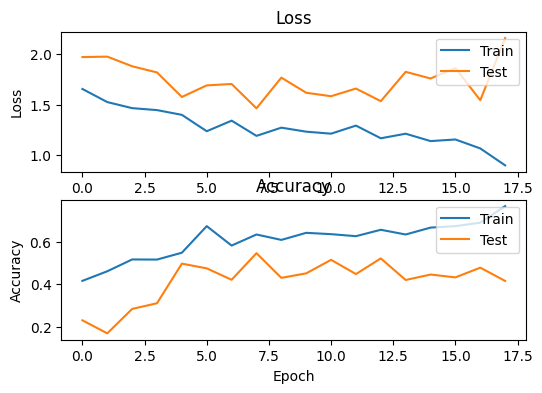

In [ ]:
def get_history(history, figsize=(6, 4)):
    fig, ax = plt.subplots(2, 1, figsize=figsize)
    ax[0].plot(history.history["loss"])
    ax[0].plot(history.history["val_loss"])
    ax[1].plot(history.history["accuracy"])
    ax[1].plot(history.history["val_accuracy"])
    ax[0].set_title("Loss")
    ax[1].set_title("Accuracy")
    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Accuracy")
    ax[0].set_xlabel("Epoch")
    ax[1].set_xlabel("Epoch")
    ax[0].legend(["Train", "Test"], loc="upper right")
    ax[1].legend(["Train", "Test"], loc="upper right")
    plt.show()


get_history(H)
